In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc
from python_speech_features import logfbank
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.layers import BatchNormalization
import pickle
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.layers import MaxPooling2D, GlobalAveragePooling2D

Using TensorFlow backend.


In [100]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [43]:
from keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras import regularizers

In [2]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

def populate_clean(df, cleanFolderPath, wavfilesPath):
#     i=0
    for f in tqdm(df.index):
#         i+=1
#         print(i)
        rate, signal = wavfile.read(wavfilesPath+f)
        mask = envelope(signal, rate, 20)

        wavfile.write(cleanFolderPath+f, rate, signal[mask])

#Configuration of data
class Config:
    def __init__(self, nfeat=128, nfft=2048, rate=44100):
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/5)# Each sample no contains (44100/5) data points which are passed to mel    

In [55]:
#===============================================================================
# Builds MFCC by taking all the wav files in clean folder
#===============================================================================
def build_mfcc(config, cleanFolderPath, df, classes, mode):
    c = config
    X = []
    y = []
    _min, _max = float('inf'), float('-inf')
    for f in tqdm(df.index):
        rate, wav = wavfile.read(cleanFolderPath+f)
        wav = wav.astype(float)
        label = df.at[f, 'label']
        step = c.step
#         manual = int(df.at[f, 'manually_verified'])
#         print(mode, manual)
        if len(wav)<1000:
            continue 
#         if mode==1 and manual!=1:
#             continue
        for i in range(0, len(wav), step):
#             print("In")
            partition = i+step
            if step > wav.shape[0]:
                signal = np.zeros((step, 1))
                signal[:wav.shape[0], :] = wav.reshape(-1, 1)
                X_mfcc = mfcc(signal, rate, numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
            elif partition > len(wav):
                X_mfcc = mfcc(wav[-step:], rate, numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
            else:
                X_mfcc = mfcc(wav[i:i+step], rate, numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
            _min = min(np.amin(X_mfcc), _min)
            _max = max(np.amax(X_mfcc), _max)
            X.append(X_mfcc)
            y.append(classes.index(label)) # Assigning an integer for a string
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
#     print(_min, _max)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = to_categorical(y, num_classes=len(classes)) # Converts to onehot vector
    return X, y

In [4]:
wavfilesPathTrain = "FSDKaggle2018.audio_train/"
wavfilesPathTest = "FSDKaggle2018.audio_test/"
#     csvFilePaths = path+"FSDKaggle2018Meta/"
cleanFolderPathTrain = "clean_train_highmel/"
cleanFolderPathTest = "clean_test_highmel/"

reqLabels = ["Saxophone", "Violin_or_fiddle", "Hi-hat", "Snare_drum", "Acoustic_guitar", "Double_bass", "Cello", "Bass_drum", "Flute", "Clarinet", "Chime", "Cowbell", "Electric_piano", "Glockenspiel", "Gong", "Harmonica", "Oboe", "Tambourine", "Trumpet"]

## Now populating Training cleaned data
dfTrain = pd.read_csv('train_post_competition.csv')
dfTrain.set_index('fname', inplace=True)

for f in dfTrain.index:
    lab = dfTrain.at[f, 'label']
    manual = dfTrain.at[f, 'manually_verified']
    if (lab not in reqLabels) or (manual == 0):
        dfTrain.drop(f, inplace = True)
        
populate_clean(dfTrain, cleanFolderPathTrain, wavfilesPathTrain)

100%|██████████| 2068/2068 [03:58<00:00,  8.68it/s]


In [14]:
config = Config()
classes = list(np.unique(dfTrain.label))
mode = 1
XTrain, yTrain = build_mfcc(config, cleanFolderPathTrain, dfTrain, classes, mode)

100%|██████████| 2068/2068 [04:15<00:00,  8.10it/s]


In [17]:
input_shape = (XTrain.shape[1], XTrain.shape[2], 3)
y_flat = np.argmax(yTrain, axis=1)
# input_shape = (XTrain.shape[1], XTrain.shape[2], 1)
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

In [19]:
needed_1 = np.zeros((XTrain.shape[0], XTrain.shape[1], 32))
needed = np.reshape(XTrain, (XTrain.shape[0], XTrain.shape[1], 19))
needed_1[:,:,:19] = needed

XTrainR = np.zeros((XTrain.shape[0], XTrain.shape[1], 32, 3))
XTrainR[:, :, :, 0] = needed_1
XTrainR[:, :, :, 1] = needed_1
XTrainR[:, :, :, 2] = needed_1

In [20]:
input_shape = (XTrainR.shape[1], XTrainR.shape[2], 3)

In [21]:
XTrainR1 = np.zeros((XTrainR.shape[0], XTrainR.shape[1], XTrainR.shape[2], 1))
XTrainR1[:, :, :, 0] = needed_1

In [39]:
def convolutionModel2():
    newModel = Sequential()
    model1 = load_model("ConvModel2.h5")
    i=0
    for layer in model1.layers:
        if i==3 or i==5:
            layer.kernel_regularizer = regularizers.l2(0.02)
        newModel.add(layer)
        if i==9:
            newModel.add(Dropout(0.5))
        i+=1
    model1 = newModel
    sgd = SGD(lr=0.0005, decay=1e-3, momentum=0.9)
    model1.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ["accuracy"])
    model1.summary()
    return model1

In [44]:
from datetime import datetime
start = datetime.now()
input_shape = (XTrainR1.shape[1], XTrainR1.shape[2], 1)
model2 = convolutionModel2()
checkpoint = ModelCheckpoint('ConvModel2_edit.h5', period=1)
model2.fit(XTrainR1, yTrain, epochs=20, batch_size=256, shuffle=True, class_weight=class_weight, validation_split=0.15, callbacks=[checkpoint])
model2.save("ConvModel2_edit.h5")
duration = datetime.now() - start
print("Training completed in time: ", duration)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 16, 64)        1664      
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 16, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 8, 64)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 8, 64)         36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 8, 64)         256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 8, 128)        73856     
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 8, 128)      

In [54]:
dfTest = pd.read_csv('test_post_competition_scoring_clips.csv')
dfTest.set_index('fname', inplace=True)

dfTest = dfTest[dfTest.label.isin(reqLabels)]

populate_clean(dfTest, cleanFolderPathTest, wavfilesPathTest)

100%|██████████| 890/890 [01:00<00:00, 14.70it/s]


In [56]:
config = Config()
classes_test = list(np.unique(dfTest.label))
mode = 1
XTest, yTest = build_mfcc(config, cleanFolderPathTest, dfTest, classes_test, mode)

100%|██████████| 890/890 [01:47<00:00,  8.25it/s]


In [89]:
y_flat_test = np.argmax(yTest, axis=1)
input_shape = (XTest.shape[1], XTest.shape[2], 1)
class_weight_test = compute_class_weight('balanced', np.unique(y_flat_test), y_flat_test)

In [86]:
needed_2 = np.zeros((XTest.shape[0], XTest.shape[1], 32))
needed2 = np.reshape(XTest, (XTest.shape[0], XTest.shape[1], 19))
needed_2[:,:,:19] = needed2

XTestR = np.zeros((XTest.shape[0], XTest.shape[1], 32, 3))
XTestR[:, :, :, 0] = needed_2
XTestR[:, :, :, 1] = needed_2
XTestR[:, :, :, 2] = needed_2



In [93]:
XTestR1 = np.zeros((XTest.shape[0], XTest.shape[1], XTest.shape[2], 1))
XTestR1[:, :, :, 0] = needed_2

ValueError: could not broadcast input array from shape (20307,128,32) into shape (20307,128,19)

In [112]:
vggmodel = load_model('vgg_highmel.h5')

In [113]:
sgd = SGD(lr=0.005,momentum=0.9,decay=0.005)
vggmodel.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ["accuracy"])

In [114]:
# checkpoint = ModelCheckpoint('vgg_highmel_test.h5', period=1)
# vggmodel.fit(XTestR[:7000], yTest[:7000], epochs=40, batch_size=512, shuffle=True, class_weight=class_weight, validation_split=0.15, callbacks=[checkpoint])
# vggmodel.save("vgg_highmel_test.h5")

In [129]:
ypred_vgg_test = vggmodel.predict(XTestR)

In [130]:
ypred_vgg_test_flat = np.argmax(ypred_vgg_test, axis=1)

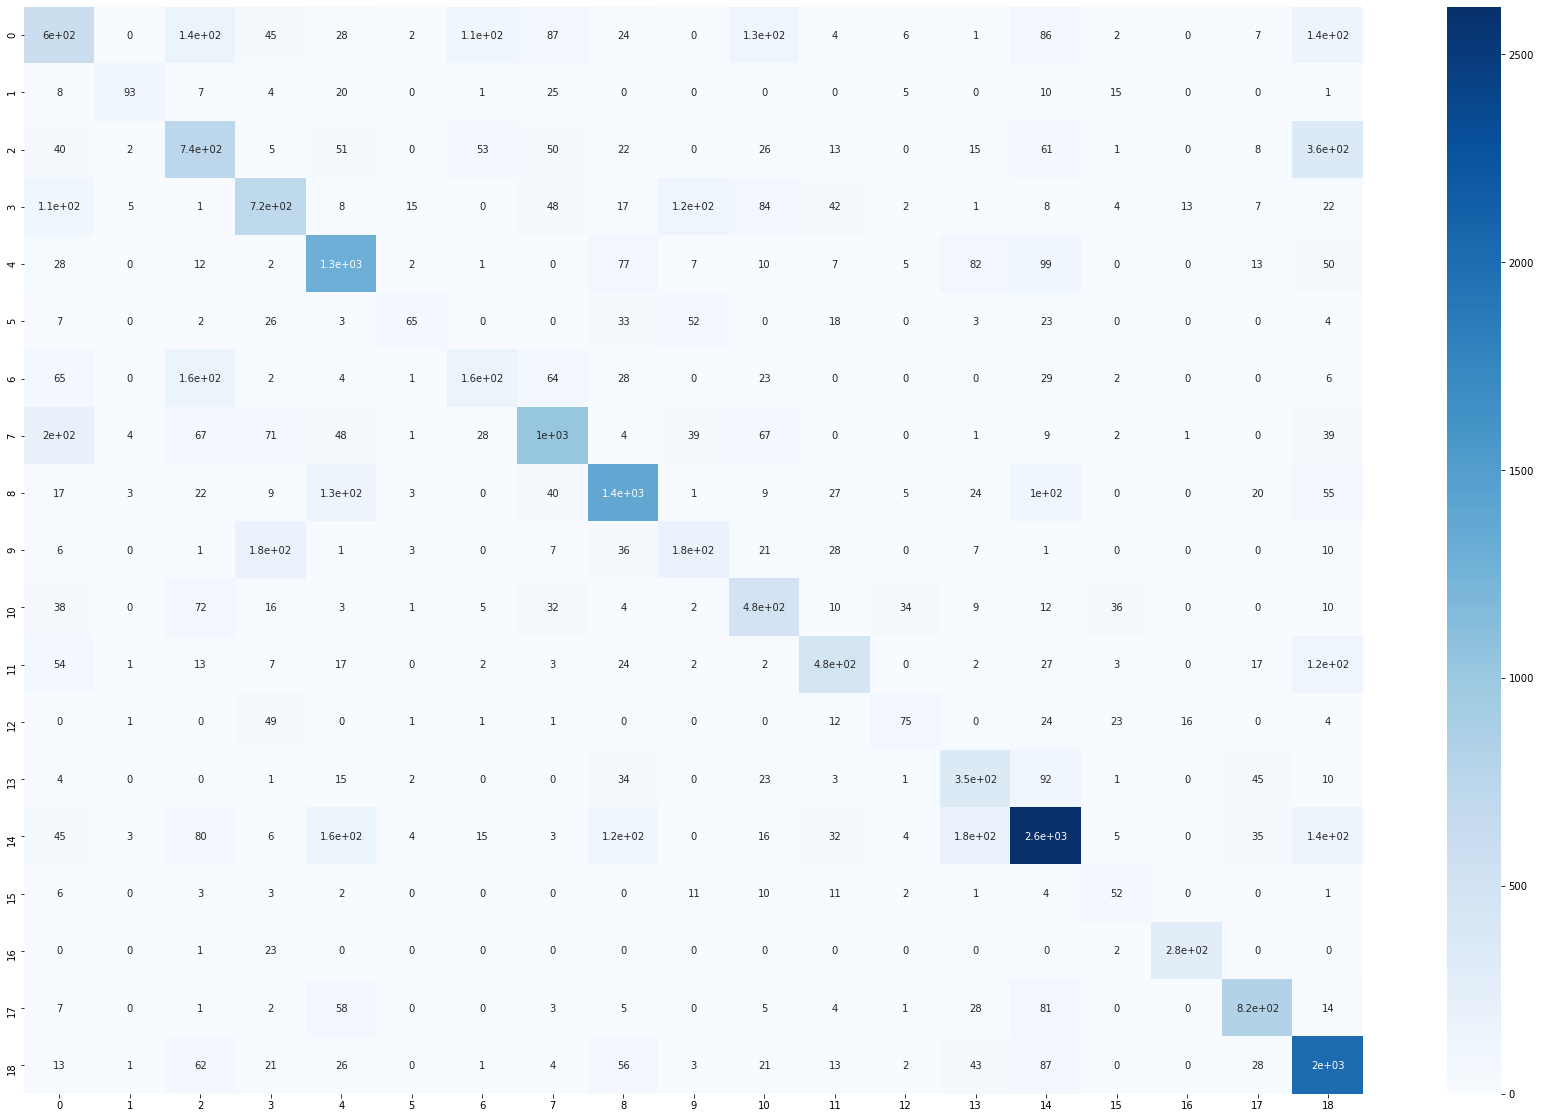

In [131]:
import seaborn as sn
cm_cgg_pred = confusion_matrix(y_flat_test,ypred_vgg_test_flat)
df_cm_cgg_pred = pd.DataFrame(cm_cgg_pred, index = list(set(ypred_vgg_test_flat)),
                  columns = list(set(ypred_vgg_test_flat)))
plt.figure(figsize = (30,20))
sn.heatmap(df_cm_cgg_pred, annot=True,cmap='Blues')

In [132]:
print(classification_report(y_flat_test,ypred_vgg_test_flat))

              precision    recall  f1-score   support

           0       0.48      0.43      0.45      1407
           1       0.82      0.49      0.62       189
           2       0.53      0.51      0.52      1447
           3       0.61      0.59      0.60      1234
           4       0.69      0.77      0.73      1690
           5       0.65      0.28      0.39       236
           6       0.42      0.29      0.34       540
           7       0.74      0.64      0.68      1610
           8       0.74      0.75      0.74      1856
           9       0.43      0.38      0.40       479
          10       0.52      0.63      0.57       764
          11       0.68      0.61      0.65       775
          12       0.53      0.36      0.43       207
          13       0.47      0.60      0.53       579
          14       0.78      0.76      0.77      3456
          15       0.35      0.49      0.41       106
          16       0.90      0.91      0.91       302
          17       0.82    

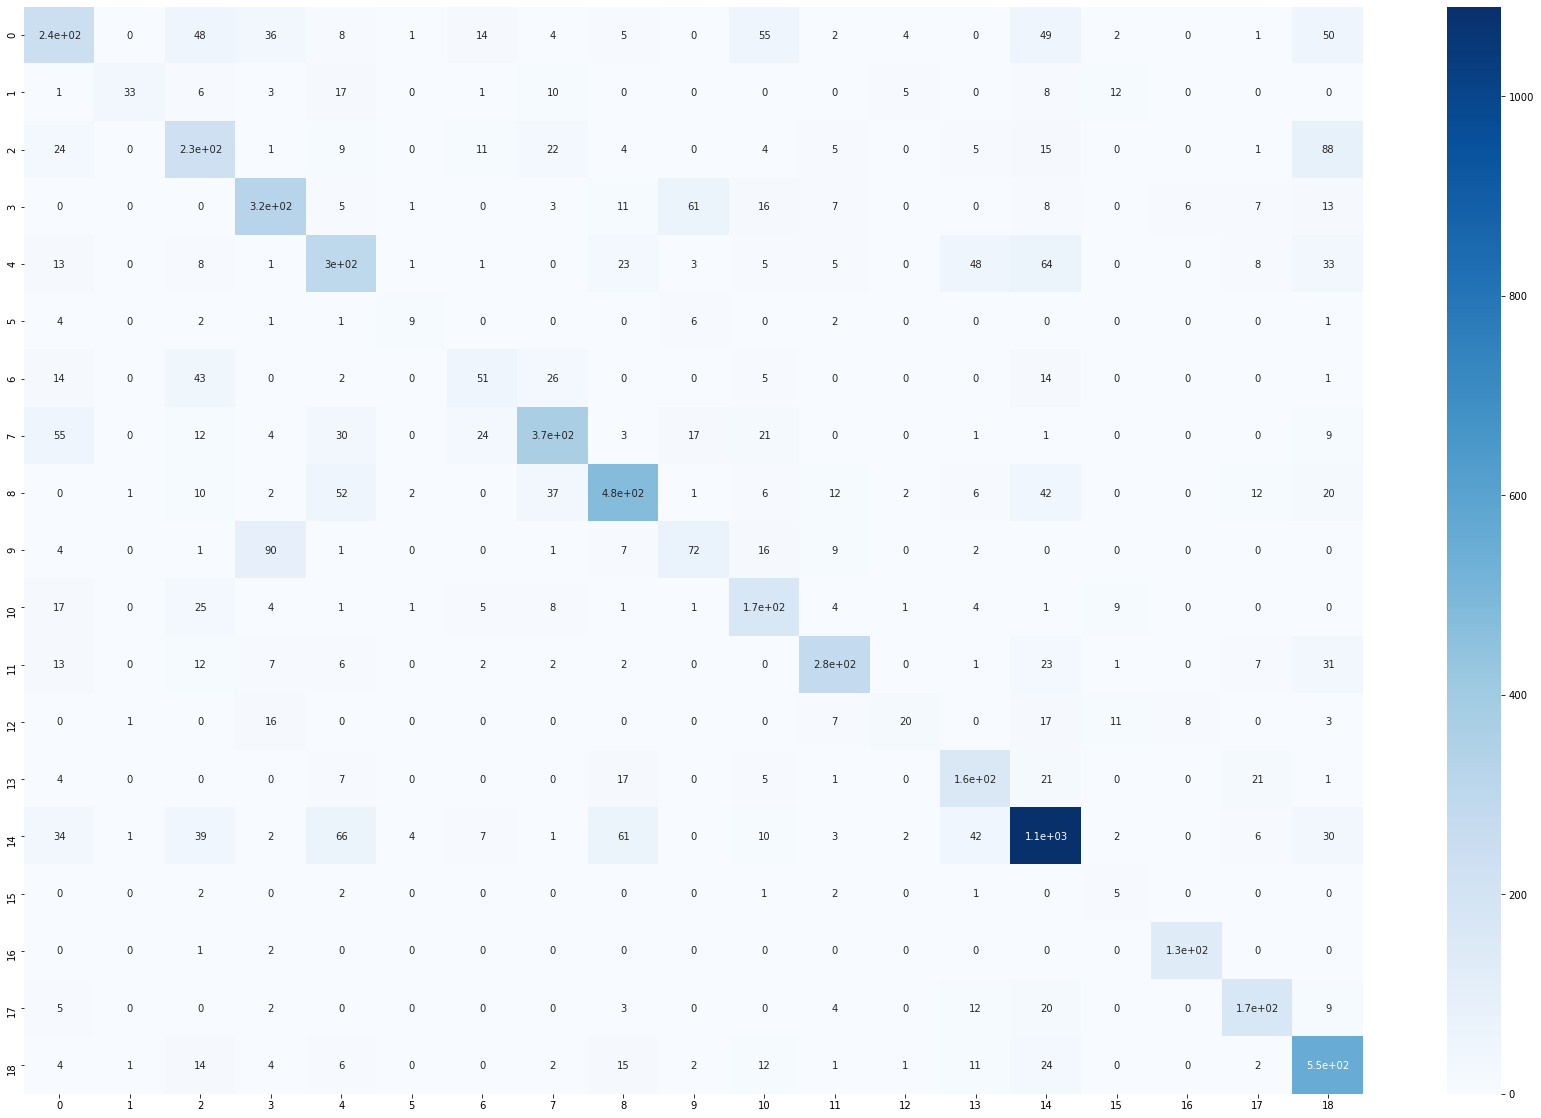

In [119]:
import seaborn as sn
cm_cgg_pred = confusion_matrix(y_flat_test[:7000],ypred_vgg_test_flat[:7000])
df_cm_cgg_pred = pd.DataFrame(cm_cgg_pred, index = list(set(ypred_vgg_test_flat[:7000])),
                  columns = list(set(ypred_vgg_test_flat[:7000])))
plt.figure(figsize = (30,20))
sn.heatmap(df_cm_cgg_pred, annot=True,cmap='Blues')

In [125]:
ypred_vgg_test = vggmodel.predict(XTrainR[:7214])
ypred_vgg_test_flat = np.argmax(ypred_vgg_test, axis=1)

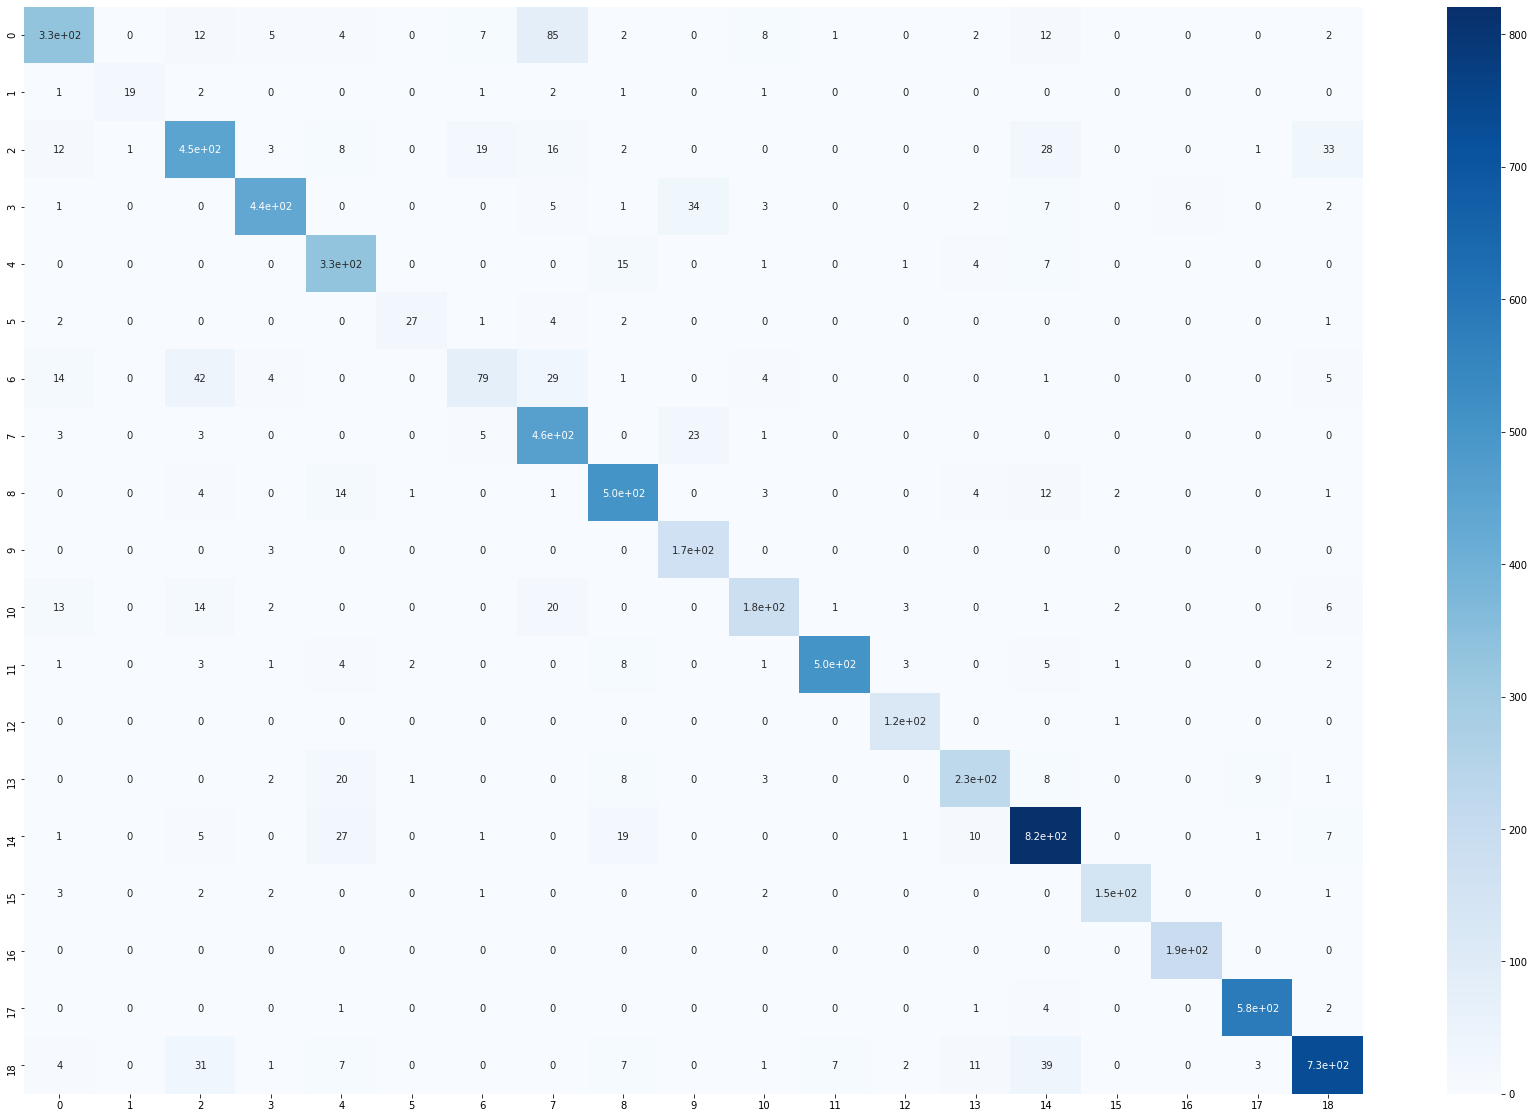

In [126]:
cm_cgg_pred = confusion_matrix(y_flat[:7214],ypred_vgg_test_flat)
df_cm_cgg_pred = pd.DataFrame(cm_cgg_pred, index = list(set(ypred_vgg_test_flat)),
                  columns = list(set(ypred_vgg_test_flat)))
plt.figure(figsize = (30,20))
sn.heatmap(df_cm_cgg_pred, annot=True,cmap='Blues')

In [128]:
print(classification_report(y_flat[:7214],ypred_vgg_test_flat))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       471
           1       0.95      0.70      0.81        27
           2       0.79      0.78      0.79       571
           3       0.95      0.88      0.91       497
           4       0.80      0.92      0.85       361
           5       0.87      0.73      0.79        37
           6       0.69      0.44      0.54       179
           7       0.74      0.93      0.82       494
           8       0.88      0.92      0.90       547
           9       0.75      0.98      0.85       170
          10       0.87      0.75      0.80       244
          11       0.98      0.94      0.96       536
          12       0.92      0.99      0.96       120
          13       0.87      0.81      0.84       278
          14       0.87      0.92      0.89       893
          15       0.96      0.93      0.95       161
          16       0.97      1.00      0.98       190
          17       0.98    